In [1]:
from IPython.display import Image
import collections
import csv,re,sys,os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io import wb
import locale
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
locale.setlocale(locale.LC_ALL, 'en_US.utf8')

def replaceThousands(n):
    '''Format large numbers'''
    return locale.format("%d",n, grouping=True)

In [3]:
sns.set_context('paper')

In [4]:
def setFigSize(dim=(16.5,5.5)):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(dim[0],dim[1])

###Grab CAIDA AS Data

In [5]:
if not os.path.exists('../data'):
    os.mkdir('../data')

if not os.path.exists('../data/midar-iff.nodes.geo'):
    !wget http://data.caida.org/datasets/topology/ark/ipv4/itdk/2013-04/kapar-midar-iff.nodes.geo.gz && \
        gunzip ../data/midar-iff.nodes.geo.gz


In [13]:
if False:
    !grep -v '#' midar-iff.nodes.geo | awk -F '\t' '{print $1"\t"$3}' > midar-iff.nodes.geo_reduced


###Read in Geolocated AS Data

In [5]:
df=pd.read_csv('../data/midar-iff.nodes.geo_reduced',quotechar='#',delimiter='\t',header=False,names=['id','country'])

In [6]:
df.shape

(31788985, 2)

###Get Country Names and ISO Codes

In [7]:
iso=wb.get_countries()
# 'name','iso2c'
iso.incomeLevel=iso.incomeLevel.apply(lambda x: re.sub(r'High income: nonOECD|High income: OECD','High income',x))
# Collpase OECD and non OECD high income countries

###Get Populations

In [8]:
popDf=wb.download(indicator='SP.POP.TOTL',start=2013,end=2013,country=[v for v in iso.iso2c.values if v])

popDf.index=popDf.index.reorder_levels([1,0])

/home/ubuntu/anaconda/lib/python2.7/site-packages/pandas/io/wb.py:128: UserWarning: Non-standard ISO country codes: 1A, 1W, 4E, 7E, 8S, A4, A5, A9, B8, C4, C5, C6, C7, C8, C9, EU, F1, JG, KV, L4, L5, L6, L7, M1, M2, OE, S1, S2, S3, S4, XC, XD, XE, XJ, XL, XM, XN, XO, XP, XQ, XR, XS, XT, XU, XY, Z4, Z7, ZF, ZG, ZJ, ZQ
  warnings.warn('Non-standard ISO country codes: %s' % tmp)


In [9]:
popVals=[]
countries=[]
for row in popDf.iterrows():
#    print row[0][1]
#    print row[1]['SP.POP.TOTL']
    popVals.append(row[1]['SP.POP.TOTL'])
    countries.append(row[0][1])
popDf=pd.DataFrame(data={'pop':popVals},index=countries)

In [10]:
popDf.head()

,pop
Aruba,102911
Andorra,79218
Afghanistan,30551674
Angola,21471618
Albania,2897366


In [11]:
iso=iso.join(popDf,on='name')

In [12]:
iso.head()

,adminregion,capitalCity,iso3c,incomeLevel,iso2c,latitude,lendingType,longitude,name,region,pop
0,,Oranjestad,ABW,High income,AW,12.5167,Not classified,-70.0167,Aruba,Latin America & Caribbean (all income levels),102911
1,South Asia,Kabul,AFG,Low income,AF,34.5228,IDA,69.1761,Afghanistan,South Asia,30551674
2,,,AFR,Aggregates,A9,,Aggregates,,Africa,Aggregates,NaN
3,Sub-Saharan Africa (developing only),Luanda,AGO,Upper middle income,AO,-8.81155,IBRD,13.242,Angola,Sub-Saharan Africa (all income levels),21471618
4,Europe & Central Asia (developing only),Tirane,ALB,Upper middle income,AL,41.3317,IBRD,19.8172,Albania,Europe & Central Asia (all income levels),2897366


In [13]:
iso.incomeLevel.value_counts()

High income            80
Upper middle income    53
Lower middle income    51
Aggregates             49
Low income             31
dtype: int64

In [14]:
isoHash={}

for r in iso.iterrows():
#    print r[1][4],r[1][8]
    isoHash[r[1][4]]=r[1][8]

In [15]:
df.head()

,id,country
0,node.geo N2:,SG
1,node.geo N3:,SG
2,node.geo N4:,SG
3,node.geo N5:,IL
4,node.geo N6:,FR


In [16]:
%%time
replaceRe=re.compile(r'node.geo|:')
df['idClean']=df.id.apply(lambda x:re.sub(replaceRe,'',x))
#df['idClean']=df['idClean'].apply(lambda x:re.sub(':','',x))

CPU times: user 3min 10s, sys: 2.16 s, total: 3min 12s
Wall time: 3min 10s


In [17]:
df.head()

,id,country,idClean
0,node.geo N2:,SG,N2
1,node.geo N3:,SG,N3
2,node.geo N4:,SG,N4
3,node.geo N5:,IL,N5
4,node.geo N6:,FR,N6


###Join the Dataframes

In [18]:
iso.index=iso.iso2c

In [19]:
%time df=df.join(iso,on='country')

CPU times: user 7.07 s, sys: 1.36 s, total: 8.44 s
Wall time: 8.43 s


###Clean out Aggregates

In [20]:
df[df['incomeLevel']=='Aggregates']=None
iso[iso['incomeLevel']=='Aggregates']=None

In [21]:
df.head()

,id,country,idClean,adminregion,capitalCity,iso3c,incomeLevel,iso2c,latitude,lendingType,longitude,name,region,pop
0,node.geo N2:,SG,N2,,Singapore,SGP,High income,SG,1.28941,Not classified,103.85,Singapore,East Asia & Pacific (all income levels),5399200
1,node.geo N3:,SG,N3,,Singapore,SGP,High income,SG,1.28941,Not classified,103.85,Singapore,East Asia & Pacific (all income levels),5399200
2,node.geo N4:,SG,N4,,Singapore,SGP,High income,SG,1.28941,Not classified,103.85,Singapore,East Asia & Pacific (all income levels),5399200
3,node.geo N5:,IL,N5,,,ISR,High income,IL,31.7717,Not classified,35.2035,Israel,Middle East & North Africa (all income levels),8059500
4,node.geo N6:,FR,N6,,Paris,FRA,High income,FR,48.8566,Not classified,2.35097,France,Europe & Central Asia (all income levels),65920302


In [22]:
#iso.index=iso.iso2c
iso.head()

,adminregion,capitalCity,iso3c,incomeLevel,iso2c,latitude,lendingType,longitude,name,region,pop
iso2c,,,,,,,,,,,
AW,,Oranjestad,ABW,High income,AW,12.5167,Not classified,-70.0167,Aruba,Latin America & Caribbean (all income levels),102911
AF,South Asia,Kabul,AFG,Low income,AF,34.5228,IDA,69.1761,Afghanistan,South Asia,30551674
NaN,None,None,None,None,None,None,None,None,None,None,NaN
AO,Sub-Saharan Africa (developing only),Luanda,AGO,Upper middle income,AO,-8.81155,IBRD,13.242,Angola,Sub-Saharan Africa (all income levels),21471618
AL,Europe & Central Asia (developing only),Tirane,ALB,Upper middle income,AL,41.3317,IBRD,19.8172,Albania,Europe & Central Asia (all income levels),2897366


In [ ]:
'''
%%time
nodeGeoHash=collections.OrderedDict()
# Node #X=>country Y

for r in df.iterrows():
#    print r[1][1],r[1][2]
    nodeGeoHash[r[1][2]]=r[1][1]
#    sys.exit(1)
'''

In [23]:
levelHash={}

for r in iso.iterrows():
#    print r[1][8]
#    print r[1][8],r[1][3]
    levelHash[r[1][8]]=r[1][3]

In [24]:
#df['fullName']=df['country'].apply(lambda x:isoHash.get(x))
#df['level']=df['country'].apply(lambda x:levelHash.get(x))

In [25]:
iso[iso.iso2c=='GB'].incomeLevel.values[0]

u'High income'

In [26]:
df.head()

,id,country,idClean,adminregion,capitalCity,iso3c,incomeLevel,iso2c,latitude,lendingType,longitude,name,region,pop
0,node.geo N2:,SG,N2,,Singapore,SGP,High income,SG,1.28941,Not classified,103.85,Singapore,East Asia & Pacific (all income levels),5399200
1,node.geo N3:,SG,N3,,Singapore,SGP,High income,SG,1.28941,Not classified,103.85,Singapore,East Asia & Pacific (all income levels),5399200
2,node.geo N4:,SG,N4,,Singapore,SGP,High income,SG,1.28941,Not classified,103.85,Singapore,East Asia & Pacific (all income levels),5399200
3,node.geo N5:,IL,N5,,,ISR,High income,IL,31.7717,Not classified,35.2035,Israel,Middle East & North Africa (all income levels),8059500
4,node.geo N6:,FR,N6,,Paris,FRA,High income,FR,48.8566,Not classified,2.35097,France,Europe & Central Asia (all income levels),65920302


In [27]:
df.idClean.values[0]

' N2'

In [28]:
levelValues=iso.incomeLevel.values
levels=iso.incomeLevel.unique()

In [29]:
iso.incomeLevel.value_counts()

High income            80
Upper middle income    53
Lower middle income    51
Low income             31
dtype: int64

In [30]:
colourHash={}

colours=sns.color_palette("dark",n_colors=len(levels))

for level, colour in zip(levels,colours):
    if level:
        colourHash[level]=colour

In [31]:
print levels

[u'High income' u'Low income' None u'Upper middle income'
 u'Lower middle income']


In [32]:
counts=df.name.value_counts()

In [33]:
perCapitaDf=pd.DataFrame(index=counts.index,data={'perCapita':counts.values})

In [34]:
perCapitaDf.head()

,perCapita
United States,7842269
China,6049794
"Korea, Rep.",2076298
Germany,1656025
Brazil,1209704


In [35]:
perCapitaDf=iso.join(perCapitaDf,on='name')

In [36]:
perCapitaDf.perCapita=perCapitaDf.perCapita/perCapitaDf['pop']

In [42]:
iso['counts']=counts

In [63]:
perCapitaDf.sort(columns='perCapita',ascending=True,inplace=True)

In [79]:
perCapitaDf.iloc[-70:]

,adminregion,capitalCity,iso3c,incomeLevel,iso2c,latitude,lendingType,longitude,name,region,pop,perCapita
iso2c,,,,,,,,,,,,
SG,,Singapore,SGP,High income,SG,1.28941,Not classified,103.85,Singapore,East Asia & Pacific (all income levels),5399200,0.015981
FI,,Helsinki,FIN,High income,FI,60.1608,Not classified,24.9525,Finland,Europe & Central Asia (all income levels),5438972,0.016666
NL,,Amsterdam,NLD,High income,NL,52.3738,Not classified,4.89095,Netherlands,Europe & Central Asia (all income levels),16804432,0.017393
FR,,Paris,FRA,High income,FR,48.8566,Not classified,2.35097,France,Europe & Central Asia (all income levels),65920302,0.017690
BM,,Hamilton,BMU,High income,BM,32.3293,Not classified,-64.706,Bermuda,North America,65001,0.019723
IS,,Reykjavik,ISL,High income,IS,64.1353,Not classified,-21.8952,Iceland,Europe & Central Asia (all income levels),323764,0.019872
LU,,Luxembourg,LUX,High income,LU,49.61,Not classified,6.1296,Luxembourg,Europe & Central Asia (all income levels),543360,0.020092
DE,,Berlin,DEU,High income,DE,52.5235,Not classified,13.4115,Germany,Europe & Central Asia (all income levels),80645605,0.020535
SE,,Stockholm,SWE,High income,SE,59.3327,Not classified,18.0645,Sweden,Europe & Central Asia (all income levels),9600379,0.024020


In [50]:
finalDf=perCapitaDf.join(pd.DataFrame(counts,columns=['counts']),on='name')

In [83]:
finalDf.sort(columns='perCapita',inplace=True)

In [89]:
finalDf=finalDf[~pd.isnull(finalDf.perCapita)]

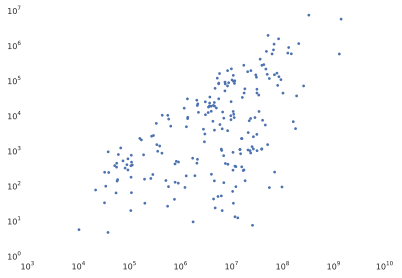

In [56]:
plt.loglog(finalDf['pop'].values,finalDf['counts'].values,'.')

In [38]:
countsHash=counts.to_dict()

###Plot AS Counts

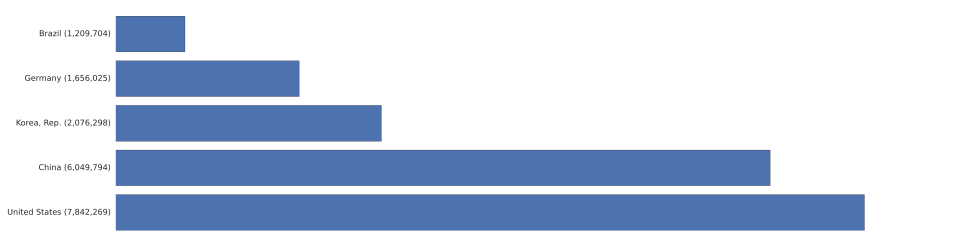

In [106]:
n=len(counts)
n=5
direction=-1
direction=1

if not n==len(counts):
    setFigSize(dim=(15,4))
else:
    setFigSize(dim=(15,35))

barList=plt.barh(range(n),counts.values[::direction][0:n],0.8,log=True)
trash=plt.yticks([r+0.4 for r in range(n)],[c+' ('+replaceThousands(countsHash[c])+')' for n,c in enumerate(counts.index[::direction][0:n])])

if n==len(counts):

    for n,bar in enumerate(barList):
        bar.set_color(colourHash[levelHash[counts.index[::direction][n]]])
    #    print counts.index[::-1][n],levelHash[counts.index[::-1][n]]
    #sys.exit(1)
    for n,(k,v) in enumerate(colourHash.items()):
    #    print k,v
        plt.annotate(k,xy=(0.05,0.91-(n*0.013)),xycoords='figure fraction',fontsize=24,color=v)

plt.xticks([],[])
        
if not n==len(counts):
    plt.savefig('../charts/as_count_'+str(n)+'.png',dpi=200)
else:
    plt.savefig('../charts/as_count.png',dpi=200)    

###Plot AS Per Capita

0 KR
adminregion      East Asia & Pacific (developing only)
capitalCity                                  Pyongyang
iso3c                                              PRK
incomeLevel                                 Low income
iso2c                                               KP
latitude                                       39.0319
lendingType                             Not classified
longitude                                      125.754
name                                  Korea, Dem. Rep.
region         East Asia & Pacific (all income levels)
pop                                       2.489548e+07
perCapita                                 3.213435e-07
counts                                               8
Name: KP, dtype: object
1 DK
adminregion      Sub-Saharan Africa (developing only)
capitalCity                                 N'Djamena
iso3c                                             TCD
incomeLevel                                Low income
iso2c                              

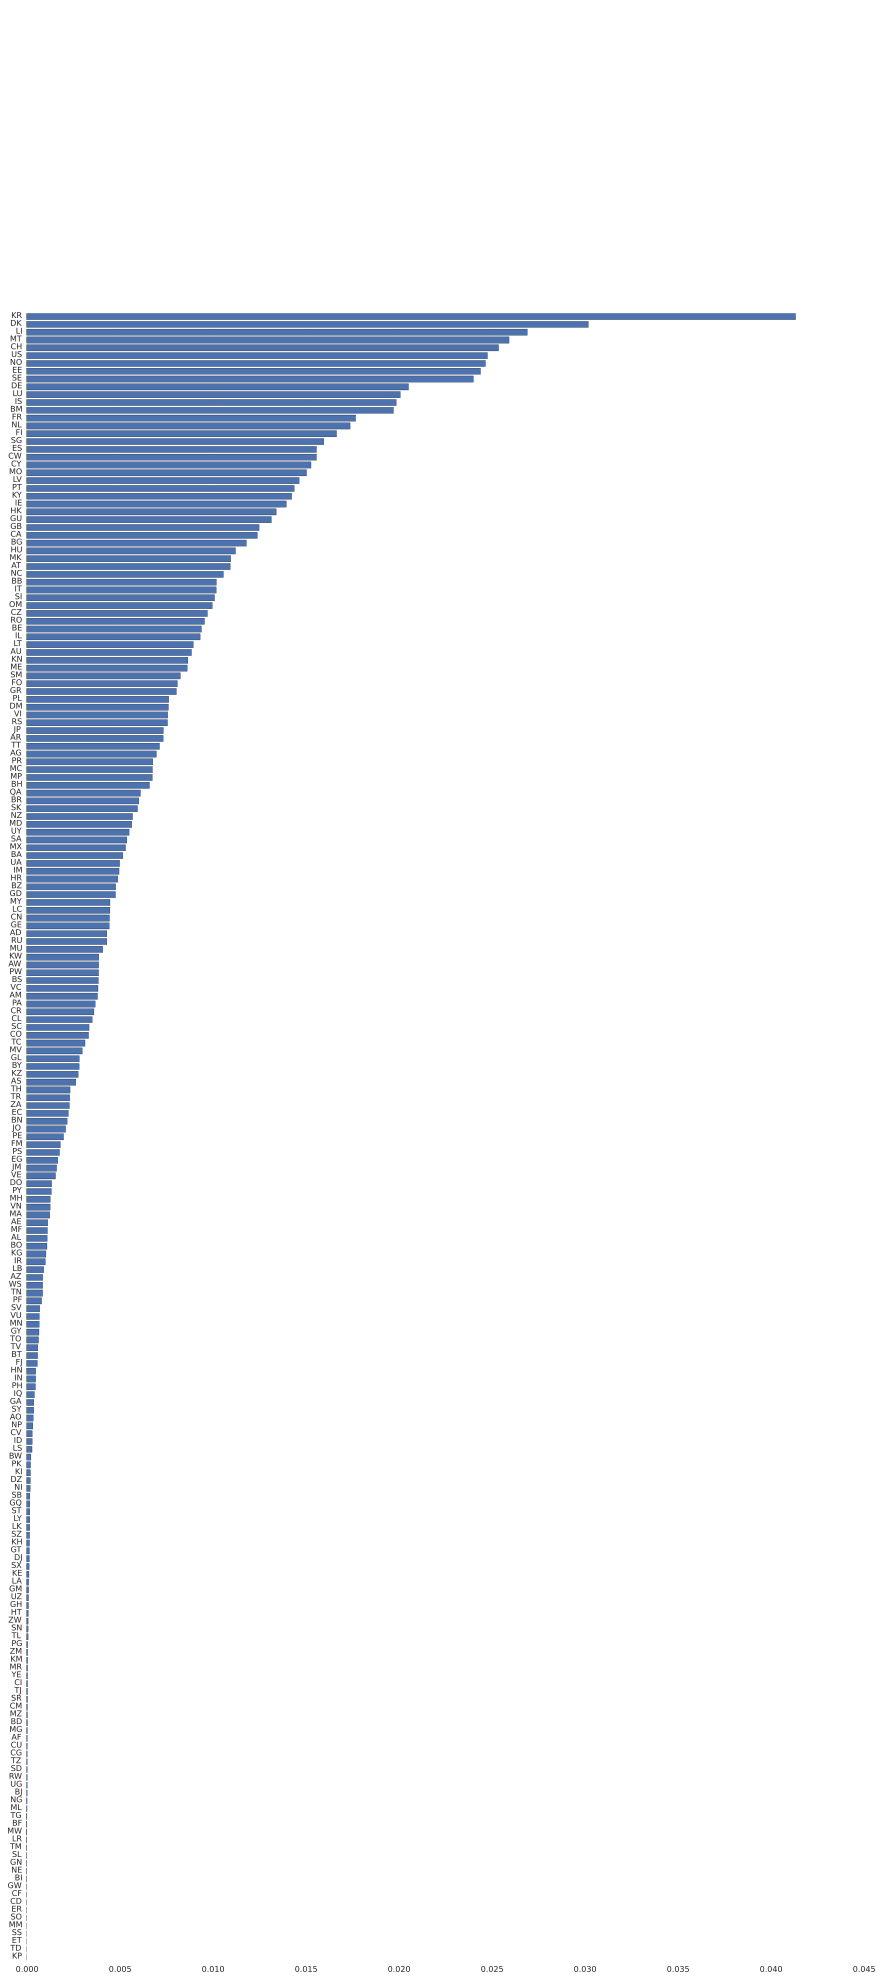

In [96]:
setFigSize(dim=(15,35))
barList=plt.barh(range(finalDf.shape[0]),finalDf.perCapita.values,0.8)
trash=plt.yticks([r+0.5 for r in range(finalDf.shape[0])],[c for n,c in enumerate(finalDf.index)])
# +' ('+replaceThousands(countsHash[c])+')'
for n,bar in enumerate(barList):
    print n, finalDf.index.values[::-1][n]
    row=finalDf.irow(n)
    print row[]
#    print levelHash[finalDf.index.values[::-1][n]]
plt.savefig('../charts/as_per_capita_count.png',dpi=200)

###Now look at edges between countries

In [43]:
edgeFile=csv.reader(open('../data/midar-iff.links'),delimiter=' ')

In [26]:
!sed -n 1530,1540p ../data/midar-iff.links

link L1:  N8888118:1.0.0.1 N120707 N120708 
link L2:  N8888119:1.0.0.2 N120709 N120710 N106378 N120711 N120712 
link L3:  N8888120:1.0.0.6 N106378 N120711 
link L4:  N8888121:1.0.0.13 N120713 
link L5:  N8888122:1.0.0.164 N120714 
link L6:  N8888123:1.0.4.10 N120715 
link L7:  N8888124:1.0.8.250 N120716 N120717 
link L8:  N8888125:1.0.20.46 N120718 
link L9:  N120718:1.0.24.22 N120719 
link L10:  N8888126:1.0.24.150 N120720 
link L11:  N699985:1.1.0.1 N120721 N120722 


In [56]:
edgeCounter=collections.Counter()
ipCounter=collections.Counter()

for line in edgeFile:
    if not re.search(r'#',line[0]):
#        print line
        source=line[3].partition(':')[0]
#        print source
#        print nodeGeoHash.get(source)
#        print line[4:-1]
        
        for dest in line[4:-1]:
            edgeCounter[(nodeGeoHash.get(source),nodeGeoHash.get(dest))]+=1

        ipCounter[source]+=1
        # Count number of IPs associated with each AS
        
#        sys.exit(1)

In [54]:
for k,v in edgeCounter.most_common():
    if not k[0]==k[1] and k[0] and k[1]:
        print k,v

('US', 'EG') 71707
('US', 'EU') 29796
('US', 'DE') 28630
('DE', 'US') 25837
('ES', 'PE') 18148
('CA', 'US') 16871
('EU', 'DE') 14785
('SE', 'NO') 14190
('GB', 'US') 14071
('BR', 'US') 13912
('US', 'CA') 12679
('US', 'AU') 11041
('DE', 'EU') 10549
('US', 'GB') 10487
('US', 'BR') 10244
('NO', 'SE') 9760
('US', 'JP') 9749
('US', 'NL') 8937
('NL', 'US') 8776
('EG', 'US') 8458
('GB', 'DE') 8341
('US', 'IN') 8319
('EU', 'US') 7772
('IN', 'US') 7612
('AR', 'US') 7280
('DK', 'US') 7198
('RU', 'US') 7115
('DE', 'GB') 7093
('NL', 'SE') 6890
('FR', 'US') 6434
('RU', 'DE') 6091
('MX', 'US') 6002
('IT', 'US') 5708
('US', 'AR') 5239
('US', 'SG') 5191
('FR', 'DE') 4902
('EU', 'GB') 4803
('DE', 'NL') 4695
('JP', 'US') 4541
('HR', 'SE') 4317
('SE', 'US') 4258
('US', 'TH') 4230
('RU', 'GB') 4198
('LT', 'SE') 4142
('DE', 'FR') 4046
('HK', 'US') 4019
('DK', 'DE') 3953
('GB', 'EU') 3827
('SE', 'NL') 3513
('BR', 'ES') 3486
('CR', 'US') 3442
('FR', 'GB') 3411
('US', 'RU') 3406
('US', 'MX') 3211
('GB', 'NL') 

In [28]:
!head ../data/midar-iff.links

# version: $Id: kapar.cc,v 1.162 2012/03/14 00:24:54 kkeys Exp $
# version: $Id: PathLoader.cc,v 1.19 2012/01/04 20:44:46 kkeys Exp $
# start time: 1367051656 (2013-04-27 01:34:16 PDT)
# command line: /home/kkeys/WIP/topology/archipelago/aliasResolution/midar/../kapar/kapar -il -py -r31 -sir -c0.5 -nv -adms -d1 -mn -lb -1a -oals -O /scratch/alias-resolution/run-20130422/kapar/midar-iff -z 24
#   -B /scratch/alias-resolution/run-20130422/bogon-bn-agg-20130422.txt
#   -A /scratch/alias-resolution/run-20130422/kapar/midar-iff.pairs
#   -P /san5/topology/ark/data/team-probing/list-7.allpref24/team-1/daily/2013/cycle-20130407/daily.l7.t1.c002462.20130407.ams3-nl.warts.gz
#   -P /san5/topology/ark/data/team-probing/list-7.allpref24/team-1/daily/2013/cycle-20130407/daily.l7.t1.c002462.20130407.amw-us.warts.gz
#   -P /san5/topology/ark/data/team-probing/list-7.allpref24/team-1/daily/2013/cycle-20130407/daily.l7.t1.c002462.20130407.bcn-es.warts.gz
#   -P /san5/topology/ark/data/team-probing/lis

In [70]:
nodesDf=pd.read_csv('../data/midar-iff.nodes_count',delimiter='  ',header=False,names=['id','n'])

In [71]:
nodesDf.head()

,id,n
0,N2,697
1,N3,681
2,N4,630
3,N5,548
4,N6,359


In [72]:
nodesDf['country']=nodesDf['id'].apply(lambda x:nodeGeoHash.get(x))

In [73]:
nodesDf.head()

,id,n,country
0,N2,697,SG
1,N3,681,SG
2,N4,630,SG
3,N5,548,IL
4,N6,359,FR


In [78]:
groups=nodesDf.groupby('country')

In [84]:
aggregated=groups.agg(np.sum)

In [86]:
aggregated.head()

,n
country,
A1,11397
A2,9724
AD,1026
AE,32211
AF,3220


In [88]:
aggregated.sort('n',ascending=False)

,n
country,
US,23600900
CN,18204066
KR,6239463
DE,4978297
BR,3633394
FR,3503206
JP,2819883
GB,2417173
ES,2182683
